In [2]:
# Libraries
import pandas as pd
import numpy as np
import math
import time
import hmac
import hashlib
import matplotlib.pyplot as plt
from nltk import ngrams
from bitarray import bitarray

First, we will convert the raw URLs into Bloom encodings. 

In [2]:
data = pd.read_csv('baseline_dataset.csv')
data.drop(data.columns[0], axis=1, inplace=True)
data

,url,label
0,https://oregonstateparks.org/index.cfm?do=geti...,0
1,http://business.hsbc.com.camaract.mobi/system_...,1
2,http://facebook.com-source-page.com/help/conta...,1
3,http://michaelnielsen.org/blog/lecture-course-...,0
4,http://messagerie-17fr.com/fr/91da56ae94f5f4ff...,1
...,...,...
468335,http://www.53.com.wps0177m.zarit.tk/confirm/cb...,1
468336,https://www.somethingsimilar.com/2013/12/09/a-...,0
468337,http://tinyurl.com/l8v5dxu,1
468338,http://162.144.71.74/serv/e402b4beddb6aba50327...,1


Now we define two functions. The first will take the input and remove all special characters, the second will split the input into n-grams

In [3]:
# No longer needed, this function removes special characters and splits input into q-grams. 
# However, this leads to information loss, therefore it makes more sense to keep them in.

# def split_into_tokenized_ngrams(url, n):
    # This function splits the input into tokens by delimiters defined by RFC3986 Standard
    # Removes all special characters and converts input into array of tokens
    # tokens = [i for i in re.split(r"[:/?#\[\]@!$&\'()*+,;=.\-_~]", url) if i]
    # Concats the tokens into a single string using blank space
    # concated = ''.join(tokens)
    # Call N-gram function to split the tokenized string into n-grams
    # return split_into_ngrams(concated, n)

start = time.time()

def split_into_ngrams(url, n):
    # This function takes the input and splits it into n-grams
    # This will ouput a list of tuples
    tuples = list(ngrams(url, n)) 
    # This converts the list of tuples into a list of strings
    concated = [''.join(tuple) for tuple in tuples]
    return concated

# Apply two functions to dataframe, creating two new columns, one where URL was split into tokens first and one where it wasn't
# Again, since the other approach with removed special characters is no longer used, we only do it for the first function

data['ngrams'] = data['url'].apply(lambda url: split_into_ngrams(url, n=2))
# data['token_ngrams'] = data['url'].apply(lambda url: split_into_tokenized_ngrams(url, n=2))

end = time.time()

print(data)
print(f"Elapsed time: {end - start:.2f} seconds")

                                                      url  label  \
0       https://oregonstateparks.org/index.cfm?do=geti...      0   
1       http://business.hsbc.com.camaract.mobi/system_...      1   
2       http://facebook.com-source-page.com/help/conta...      1   
3       http://michaelnielsen.org/blog/lecture-course-...      0   
4       http://messagerie-17fr.com/fr/91da56ae94f5f4ff...      1   
...                                                   ...    ...   
468335  http://www.53.com.wps0177m.zarit.tk/confirm/cb...      1   
468336  https://www.somethingsimilar.com/2013/12/09/a-...      0   
468337                         http://tinyurl.com/l8v5dxu      1   
468338  http://162.144.71.74/serv/e402b4beddb6aba50327...      1   
468339    http://www.bartekbitner.pl/libraries/fof/-/din7      1   

                                                   ngrams  
0       [ht, tt, tp, ps, s:, :/, //, /o, or, re, eg, g...  
1       [ht, tt, tp, p:, :/, //, /b, bu, us, si, in, n...  
2  

The two functions above are used to generate two sets of N-grams, one where we also accept special characters and one where we only consider the text.
The next step is to create a Bloom filter and hash the N-grams into the Bloom filter.

In [14]:
def bloom_encode(input, l, k):
    # This function encodes the input into a Bloom filter of size m using k hash funtions
    # input (list): A list of n-grams to encode
    # l (int): The desired size of the Bloom filter
    # k (int): The desired number of hash functions to use
    # Returns encoded bit array

    # Initialize bitarray of size l and set all bits to 0
    bf = bitarray(l)
    bf.setall(0)

    # Iterate over each n-gram and hash it
    for ngram in input:
        for i in range(k):
            # Create a base key from the input and add one byte for each hash function
            # Example: input ('aa') generates key xdb\x95, then h_1 of 'aa' is xdb\x95\x00, h_2 of 'aa' is xdb\x95\x01, h_3 of 'aa' is xdb\x95\x02 etc.
            # Reminder: this is not cryptographically secure in any way
            key = hashlib.sha256(ngram.encode()).digest() + bytes([i])
            # Create new HMAC object with random key and ngram
            hash = hmac.new(key, ngram.encode(), digestmod='sha256')
            # Get hash value as integer, modulo l is used to keep the value between 0 and l-1
            hash_value = int(hash.hexdigest(), 16) % l
            # Set corresponding bits to 1
            bf[hash_value] = 1

    # Return bf as a binary string
    return bf.to01()

# Example input
input = ['aa', 'bb']
output = bloom_encode(input, 16, 4)

output

'0100010110001010'

Now we apply the function to the dataframe

In [10]:
# This is used to create encoded datasets. 

start = time.time()

# Change parameter values here (l, k)
data['encodings'] = data['ngrams'].apply(lambda x: bloom_encode(x, l=512, k=4))
data.drop(columns=['url', 'ngrams'], inplace=True)
# Name dataset (I used l_k_q_dataset.csv)
data.to_csv('512_4_2_dataset.csv', index=False)

end = time.time()

print(data)
print(f"Elapsed time: {end - start:.2f} seconds")

        label                                          encodings
0           0  0100111101000110010010100001001001111001010000...
1           1  0110111110001110101011011001111111111011111110...
2           1  0110010100000100010010101001001111010110001010...
3           0  0101110000011111001010000010001000011000000000...
4           1  0111001101110111110011111101101011111100001001...
...       ...                                                ...
468335      1  0000100111000100000001000101011010011101011101...
468336      0  0100110100000110001000001101001000110101010111...
468337      1  0000100100000100000000000000001000111000000011...
468338      1  0000100000001111000010101101011001111010101001...
468339      1  0000100001000100100011010100001001111000000011...

[468340 rows x 2 columns]
Elapsed time: 3194.56 seconds


Average: 204
Min: 4
Max: 425


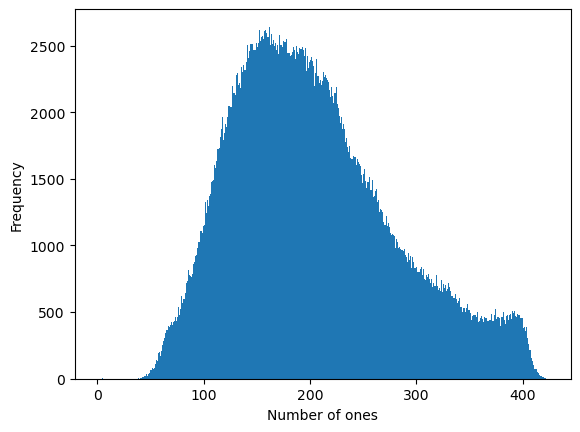

In [11]:
# Statistics
# This is tied in with the cell above, it prints the distribution of ones of the most recently encoded dataset
encodings = data['encodings'].tolist()
num_ones = [encoding.count('1') for encoding in encodings]

print(f"Average: {np.mean(num_ones):.0f}")
print(f"Min: {min(num_ones)}")
print(f"Max: {max(num_ones)}")

plt.hist(num_ones, bins=range(max(num_ones)))
plt.xlabel('Number of ones')
plt.ylabel('Frequency')

plt.savefig("ones_raw_encoding.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

Now we will encode the feature dataset

In [24]:
feature = pd.read_csv('full_zero_feature_dataset.csv')
feature

,label,features
0,0,"['ur80', 'ho20', 'pa10', 'to1', 'sl4', 'eq2', ..."
1,1,"['ur90', 'ho25', 'pa30', 'ht1', 'sl4', 'do4', ..."
2,1,"['ur60', 'ho25', 'pa30', 'ht1', 'to1', 'sl6', ..."
3,0,"['ur80', 'ho20', 'pa50', 'ht1', 'to1', 'sl4', ..."
4,1,"['ur90', 'ho20', 'pa40', 'ht1', 'to1', 'sl4', ..."
...,...,...
468335,1,"['ur60', 'ho25', 'pa20', 'ht1', 'sl4', 'do4', ..."
468336,0,"['ur80', 'ho25', 'pa40', 'to1', 'sl6', 'da4', ..."
468337,1,"['ur20', 'ho10', 'pa10', 'ht1', 'to1', 'ss1', ..."
468338,1,"['ur90', 'ho15', 'pa50', 'ip1', 'ht1', 'sl4', ..."


In [25]:
start = time.time()

# Change parameter values here
feature['feature_encodings'] = feature['features'].apply(lambda x: bloom_encode(x, l=256, k=4))
feature.drop(columns=['features'], inplace=True)
# Name dataset here
feature.to_csv('ffz_l256_k4_dataset.csv', index=False)

end = time.time()

print(feature)
print(f"Elapsed time: {end - start:.2f} seconds")

        label                                  feature_encodings
0           0  0010010001000001100001010110010011000100000100...
1           1  0000010101000001100100010110011011000100000110...
2           1  0000010101000001100000010110011011000100000110...
3           0  0010010001000001100000010110010011000100000100...
4           1  0000010001010001100101010110010011000100000100...
...       ...                                                ...
468335      1  0000010101000001100000010110011011000100000100...
468336      0  0010010001000001100000010110010011000100000100...
468337      1  0000010001000001100000010110010011000100000100...
468338      1  0000010001000001100101010110010011000100000100...
468339      1  0000010001000001100000010110010011000100000100...

[468340 rows x 2 columns]
Elapsed time: 659.65 seconds


In [ ]:
# Cell to create plots for one distribution

distribution_df = pd.read_csv('ff_l256_k4_dataset.csv')
encodings = distribution_df['feature_encodings'].tolist()
num_ones = [encoding.count('1') for encoding in encodings]

print(f"Average: {np.mean(num_ones):.0f}")
print(f"Min: {min(num_ones)}")
print(f"Max: {max(num_ones)}")

plt.hist(num_ones, bins=range(max(num_ones)))
plt.xlabel('Number of ones')
plt.ylabel('Frequency')

# plt.savefig("ones_raw_encoding.png", format="png", dpi=300, bbox_inches="tight")

plt.show()